In [1]:
from __future__ import annotations

import os
import numpy as np
import open3d as o3d
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from skimage.segmentation import find_boundaries
from scipy.ndimage import distance_transform_edt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def ensure_outdir(path="out"):
    os.makedirs(path, exist_ok=True)
    return path


def load_and_clean_cloud(cloud_path: str, nb_neighbors=20, std_ratio=2.0):
    print(f"Loading point cloud: {cloud_path}")
    pcd = o3d.io.read_point_cloud(cloud_path)
    if len(pcd.points) == 0:
        raise ValueError("Loaded point cloud is empty")
    pcd.estimate_normals()
    pcd_clean, _ = pcd.remove_statistical_outlier(
        nb_neighbors=nb_neighbors, std_ratio=std_ratio
    )
    print(f"Point cloud: {len(pcd.points)} pts, after clean: {len(pcd_clean.points)}")
    try:
        o3d.visualization.draw_geometries([pcd_clean])
    except Exception:
        pass
    return pcd_clean

In [3]:
def segment_plane_and_pca(
    pcd_clean: o3d.geometry.PointCloud,
    distance_threshold=0.04,
    ransac_n=5,
    num_iterations=500,
):
    plane_model, inliers = pcd_clean.segment_plane(
        distance_threshold=distance_threshold, ransac_n=ransac_n, num_iterations=num_iterations
    )
    plane = pcd_clean.select_by_index(inliers)
    points = np.asarray(plane.points)
    center = points.mean(axis=0)
    _, _, vt = np.linalg.svd(points - center, full_matrices=False)
    basis = vt[:2]   # PCA basis for 2D projection
    normal = vt[2]   # PCA normal to plane
    return points, basis, normal, center

In [4]:
def project_to_image(points: np.ndarray, basis: np.ndarray, center: np.ndarray, img_res=1024):
    coords_2d = (points - center) @ basis.T
    min_xy = coords_2d.min(axis=0)
    max_xy = coords_2d.max(axis=0)
    norm_coords = (coords_2d - min_xy) / (max_xy - min_xy + 1e-9)
    img_xy = np.clip((norm_coords * (img_res - 1)).astype(np.int32), 0, img_res - 1)
    mask2d = np.zeros((img_res, img_res), dtype=np.uint8)
    mask2d[img_xy[:, 1], img_xy[:, 0]] = 1
    return coords_2d, img_xy, mask2d


def rasterize_and_morph(mask2d: np.ndarray, img_xy: np.ndarray,
                        img_res=1024, r_disk: int | None = None,
                        k_close: int = 25, k_open: int = 25):
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * 6 + 1, 2 * 6 + 1))
    mask_raster = cv2.dilate(mask2d, se)

    mask255 = (mask_raster * 255).astype(np.uint8)
    mask255 = cv2.morphologyEx(mask255, cv2.MORPH_CLOSE, np.ones((k_close, k_close), np.uint8))
    mask255 = cv2.morphologyEx(mask255, cv2.MORPH_OPEN,  np.ones((k_open,  k_open ), np.uint8))
    mask255 = cv2.GaussianBlur(mask255, (5, 5), 1.0)
    mask = (mask255 > 32).astype(np.uint8)
    return r_disk, mask_raster, mask

In [5]:
def edt_ridge_skeleton(mask: np.ndarray):
    contour = find_boundaries(mask.astype(bool), mode="outer").astype(np.uint8)

    inv = np.ones_like(mask, bool)
    inv[contour.astype(bool)] = False
    edt = distance_transform_edt(inv).astype(np.float32)
    dist_map = np.zeros_like(edt, np.float32)
    dist_map[mask.astype(bool)] = edt[mask.astype(bool)]

    H, W = mask.shape
    skeleton = np.zeros_like(mask, np.uint8)
    ys, xs = np.where(mask)
    for y, x in zip(ys, xs):
        v = dist_map[y, x]
        if v <= 0:
            continue
        ok = True
        for dy in (-1, 0, 1):
            ny = y + dy
            if ny < 0 or ny >= H:
                continue
            for dx in (-1, 0, 1):
                if dx == 0 and dy == 0:
                    continue
                nx = x + dx
                if nx < 0 or nx >= W:
                    continue
                if dist_map[ny, nx] > v:
                    ok = False
                    break
            if not ok:
                break
        if ok:
            skeleton[y, x] = 1
    skeleton[contour.astype(bool)] = 0
    edges = cv2.Canny((mask * 255).astype(np.uint8), 80, 160) // 255
    return contour, dist_map, skeleton, edges

In [6]:
def visualize_steps_grid(save_path: str,
                         coords_2d: np.ndarray, mask2d: np.ndarray, r_disk: int,
                         mask_raster: np.ndarray, mask: np.ndarray,
                         contour: np.ndarray, dist_map: np.ndarray, skeleton: np.ndarray):
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))

    axs[0, 0].scatter(coords_2d[:, 0], coords_2d[:, 1], s=1, c="k")
    axs[0, 0].set_title("Projected plane points"); axs[0, 0].axis("equal"); axs[0, 0].axis("off")

    axs[0, 1].imshow(mask2d, cmap="gray")
    axs[0, 1].set_title("Raw mask2d (0/1)"); axs[0, 1].axis("off")

    axs[0, 2].imshow(mask_raster, cmap="gray")
    axs[0, 2].set_title(f"Rasterized (dilate r={r_disk}px)"); axs[0, 2].axis("off")

    axs[0, 3].imshow(mask, cmap="gray")
    axs[0, 3].set_title("After morphology"); axs[0, 3].axis("off")

    axs[1, 0].imshow(contour, cmap="gray")
    axs[1, 0].set_title("Contour"); axs[1, 0].axis("off")

    im = axs[1, 1].imshow(dist_map, cmap="magma")
    axs[1, 1].set_title("Distance map (EDT)"); axs[1, 1].axis("off")
    fig.colorbar(im, ax=axs[1, 1], shrink=0.8)

    axs[1, 2].imshow(skeleton, cmap="gray")
    axs[1, 2].set_title("Skeleton (EDT ridges)"); axs[1, 2].axis("off")

    overlay = np.stack([skeleton * 255, mask * 255, np.zeros_like(mask)], axis=-1).astype(np.uint8)
    axs[1, 3].imshow(overlay)
    axs[1, 3].set_title("Overlay (red=skeleton, green=mask)"); axs[1, 3].axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

Loading point cloud: /home/sha/Documents/aitech-robotics/ai-robo-sandbox/data_captures/first/debug/final_merged.ply
Point cloud: 7505 pts, after clean: 7124


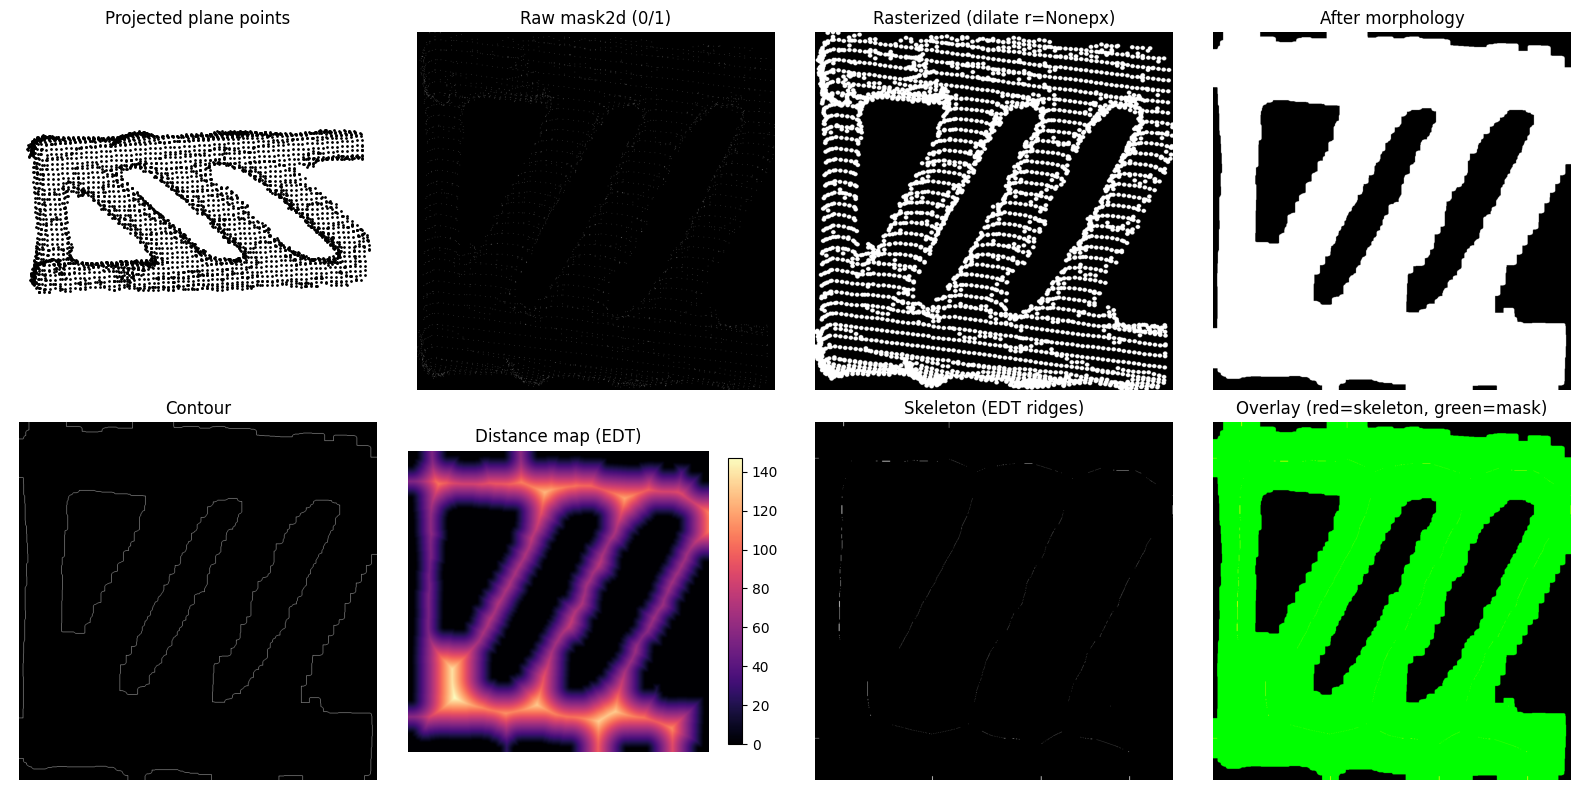

In [7]:
cloud_path = "/home/sha/Documents/aitech-robotics/ai-robo-sandbox/data_captures/first/debug/final_merged.ply"

pcd_clean = load_and_clean_cloud(cloud_path)

points, basis, normal, center = segment_plane_and_pca(
    pcd_clean, distance_threshold=0.04, ransac_n=5, num_iterations=500
)

coords_2d, img_xy, mask2d = project_to_image(points, basis, center, img_res=1024)

r_disk, mask_raster, mask = rasterize_and_morph(
    mask2d, img_xy, img_res=1024, r_disk=None, k_close=25, k_open=25
)
contour, dist_map, skeleton, edges = edt_ridge_skeleton(mask)

outdir = ensure_outdir("out")
visualize_steps_grid(
    os.path.join(outdir, "debug_grid.png"),
    coords_2d, mask2d, r_disk, mask_raster, mask, contour, dist_map, skeleton
)